In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient
from bson import ObjectId
import os
import pickle
from collections import defaultdict, Counter

In [2]:
plt.style.use('ggplot')

In [3]:
data_path = "/data/rali7/Tmp/solimanz/LBJ"

In [4]:
client = MongoClient()
collection = client.LBJ.candidats

In [110]:
collection.count_documents({})

9589320

# Distribution Over Number of Job Experiences

In [26]:
pipeline = [
    {"$match": {
        'experiences': {
            "$exists": True
        }
    }},
    {"$project": {
        "_id": 1,
        "size": {
            "$size": "$experiences"
        }
    }}
]

In [34]:
cur = collection.aggregate(pipeline)

In [35]:
n_exps = [dat['size'] for dat in cur]

In [41]:
counts = Counter(n_exps)

In [44]:
x, y = zip(*[(t[0], t[1]) for t in counts.most_common(len(counts))])

In [47]:
len(x)

97

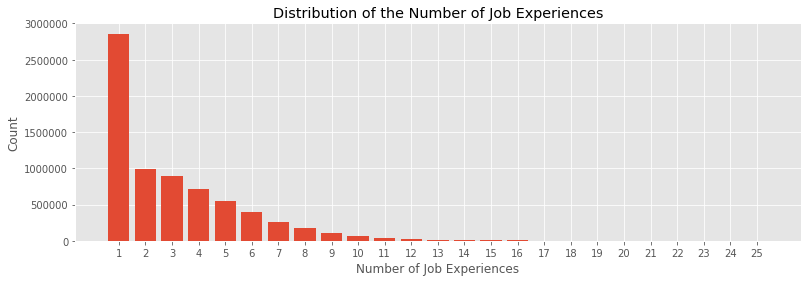

In [81]:
plt.rcParams['figure.figsize'] = 13, 4
plt.bar(x[:25], y[:25])
plt.xticks(x[:25])
plt.xlabel('Number of Job Experiences')
plt.ylabel('Count')
plt.title('Distribution of the Number of Job Experiences')
plt.savefig(os.path.join(data_path, 'viz', 'n_exps_barplot.pdf'))

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6ef40dcac8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6ef40ecf28>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6ef40ec198>],
 'medians': [<matplotlib.lines.Line2D at 0x7f6ef40f67b8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f6ef40f6be0>],
 'means': []}

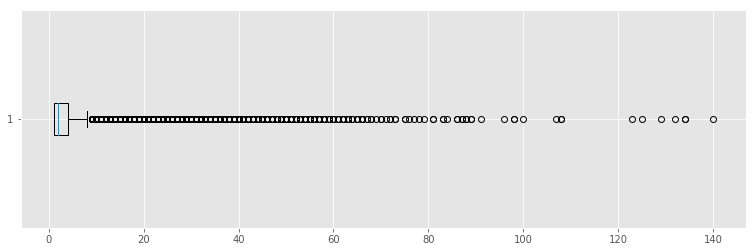

In [78]:
plt.boxplot(n_exps, vert=False)

In [16]:
pipeline = [
    {"$match": {'experiences': {"$exists": True}}},
    {"$project": {
        "_id": 1,
        "size": {
            "$size": "$experiences"
        }
    }}
]

In [17]:
cur = collection.aggregate(pipeline)

In [18]:
profile_ids = [str(d["_id"]) for d in cur]

In [21]:
collection.find({}).explain()

{'queryPlanner': {'plannerVersion': 1,
  'namespace': 'LBJ.candidats',
  'indexFilterSet': False,
  'parsedQuery': {},
  'winningPlan': {'stage': 'COLLSCAN', 'direction': 'forward'},
  'rejectedPlans': []},
 'executionStats': {'executionSuccess': True,
  'nReturned': 9589320,
  'executionTimeMillis': 21453,
  'totalKeysExamined': 0,
  'totalDocsExamined': 9589320,
  'executionStages': {'stage': 'COLLSCAN',
   'nReturned': 9589320,
   'executionTimeMillisEstimate': 20663,
   'works': 9589322,
   'advanced': 9589320,
   'needTime': 1,
   'needYield': 0,
   'saveState': 74917,
   'restoreState': 74917,
   'isEOF': 1,
   'invalidates': 0,
   'direction': 'forward',
   'docsExamined': 9589320},
  'allPlansExecution': []},
 'serverInfo': {'host': 'octal16',
  'port': 27017,
  'version': '4.0.3',
  'gitVersion': '7ea530946fa7880364d88c8d8b6026bbc9ffa48c'},
 'ok': 1.0}

In [22]:
collection.find({'experiences': {"$exists": True}}).explain()

{'queryPlanner': {'plannerVersion': 1,
  'namespace': 'LBJ.candidats',
  'indexFilterSet': False,
  'parsedQuery': {'experiences': {'$exists': True}},
  'winningPlan': {'stage': 'COLLSCAN',
   'filter': {'experiences': {'$exists': True}},
   'direction': 'forward'},
  'rejectedPlans': []},
 'executionStats': {'executionSuccess': True,
  'nReturned': 7152878,
  'executionTimeMillis': 27552,
  'totalKeysExamined': 0,
  'totalDocsExamined': 9589320,
  'executionStages': {'stage': 'COLLSCAN',
   'filter': {'experiences': {'$exists': True}},
   'nReturned': 7152878,
   'executionTimeMillisEstimate': 26514,
   'works': 9589322,
   'advanced': 7152878,
   'needTime': 2436443,
   'needYield': 0,
   'saveState': 74923,
   'restoreState': 74923,
   'isEOF': 1,
   'invalidates': 0,
   'direction': 'forward',
   'docsExamined': 9589320},
  'allPlansExecution': []},
 'serverInfo': {'host': 'octal16',
  'port': 27017,
  'version': '4.0.3',
  'gitVersion': '7ea530946fa7880364d88c8d8b6026bbc9ffa48c'},

In [24]:
collection.find({'experiences': {"$exists": True}, '$where': 'this.experiences.length > 1'}).explain()

{'queryPlanner': {'plannerVersion': 1,
  'namespace': 'LBJ.candidats',
  'indexFilterSet': False,
  'parsedQuery': {'$and': [{'experiences': {'$exists': True}},
    {'$where': Code('this.experiences.length > 1', {})}]},
  'winningPlan': {'stage': 'COLLSCAN',
   'filter': {'$and': [{'experiences': {'$exists': True}},
     {'$where': Code('this.experiences.length > 1', {})}]},
   'direction': 'forward'},
  'rejectedPlans': []},
 'executionStats': {'executionSuccess': True,
  'nReturned': 4294782,
  'executionTimeMillis': 282336,
  'totalKeysExamined': 0,
  'totalDocsExamined': 9589320,
  'executionStages': {'stage': 'COLLSCAN',
   'filter': {'$and': [{'experiences': {'$exists': True}},
     {'$where': Code('this.experiences.length > 1', {})}]},
   'nReturned': 4294782,
   'executionTimeMillisEstimate': 280383,
   'works': 9589322,
   'advanced': 4294782,
   'needTime': 5294539,
   'needYield': 0,
   'saveState': 74954,
   'restoreState': 74954,
   'isEOF': 1,
   'invalidates': 0,
   'dir

In [5]:
pipeline = [
            {"$match": {'experiences': {"$exists": True}, '$expr': 'this.experiences.length > 1'}},
            {"$unwind": {
                "path": "$experiences",
                "includeArrayIndex": "job_index"
                }
            },
            {"$project": {
                "industry": 1,
                "job_index": 1,
                "language": "$language",
                "company_name": "$experiences.companyName",
                "place": "$experiences.place",
                "function": "$experiences.function",
                "start_date": "$experiences.startDate",
                "end_date": "$experiences.endDate"
                #"mission": "$experiences.missions"
                }}
            ]

In [6]:
agg = collection.aggregate(pipeline)

In [7]:
def _get_element(doc, field_name):
    if field_name in doc:
        return doc[field_name]
    return np.nan

def make_dataframe(curr):
    data = defaultdict(list)

    for doc in curr:
        data['_id'].append(str(doc['_id']))
        data['function'].append(_get_element(doc, 'function'))
        data['company_name'].append(_get_element(doc,'company_name'))
        data['industry'].append(_get_element(doc,'industry'))
        data['job_index'].append(doc['job_index'])        
        data['place'].append(_get_element(doc, 'place'))
        data['language'].append(_get_element(doc, 'language'))
        #data['mission'].append(_get_element(doc, 'mission'))
        data['start_date'].append(_get_element(doc, 'start_date'))
        data['end_date'].append(_get_element(doc, 'end_date'))
    return data

In [8]:
df_dict = make_dataframe(agg)

In [9]:
df = pd.DataFrame(df_dict)

In [10]:
df.to_pickle(os.path.join(data_path, 'dataset', 'dataframe.pkl'))

In [16]:
df._id.nunique()

7152878

In [5]:
def load_dataset_ids(path="/data/rali7/Tmp/solimanz/LBJ/dataset"):
    with open(os.path.join(path, 'train', 'train_ids.pkl'), "rb")as f:
        train_ids = [ObjectId(i) for i in pickle.load(f)]
    with open(os.path.join(path, 'valid', 'valid_ids.pkl'), "rb")as f:
        valid_ids = [ObjectId(i) for i in pickle.load(f)]
    with open(os.path.join(path, 'test', 'test_ids.pkl'), "rb")as f:
        test_ids = [ObjectId(i) for i in pickle.load(f)]
    
    return train_ids, valid_ids, test_ids

In [6]:
train_ids, valid_ids, test_ids = load_dataset_ids()

In [7]:
ids = train_ids +  valid_ids + test_ids

In [8]:
ids = [ObjectId(i) for i in ids]

In [11]:
cur = collection.find({'_id': {'$in': ids}})

In [12]:
education = dict()
skills = dict()
industry = dict()

for doc in cur:
    _id = doc['_id']
    
    if 'educations' in doc:
        education[str(_id)] = doc['educations']
    else:
        education[str(_id)] = None
        
    if 'skills' in doc:
        skills[str(_id)] = [skill['name'] for skill in doc['skills']]
    else:
        skills[str(_id)] = None
        
    if 'industry' in doc:
        industry[str(_id)] = doc['industry']
    else:
        industry[str(_id)] = None

In [13]:
with open(os.path.join(data_path, 'dataset', 'education.pkl'), 'wb') as f:
    pickle.dump(education, f)

with open(os.path.join(data_path, 'dataset', 'skills.pkl'), 'wb') as f:
    pickle.dump(skills, f)

with open(os.path.join(data_path, 'dataset', 'industry.pkl'), 'wb') as f:
    pickle.dump(industry, f)